# Reconstruction of cellpainting image using ML

This notebook aims at reconstructing multichannel cellpating image using ML.

In [1]:
import torchvision
from torchvision.transforms import v2
import torch
import os
import sys
import numpy as np 
import lightning as L
import importlib
import shutil


# We add the correct path to the system
PATH_SCRIPTS = [
    "../",
    os.path.join(
        os.path.dirname(os.getcwd()),
        "src","gencellpainting"),
    os.path.join(
        os.path.dirname(os.getcwd()),
        "src","gencellpainting","model")        
    ]
sys.path.extend(PATH_SCRIPTS)

import gencellpainting as gc


# from gencellpainting.mdataset import CellPaintingDatasetInMemory,WGANCriticDataset
from gencellpainting.mdataset import CellPaintingDatasetInMemory,WGANCriticDataset

/home/adelabriere/miniconda3/envs/imaging/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The data as already been preprocessed into tensor of dimension C, H, W where:
* __C__ is the rnumber of channel: in this case 5
* __H__ is the heigth of the image
* __W__ is the wifdth of the image

And is stored in the folder:

In [2]:
PATH_IMAGES = "/mnt/c/Users/alexi/Documents/data/images/cellpainting/cpg0016-jump/data/resized_tensor_128_uint8"

A torch Dataset class havbe already been written for convenience, to speed up the test all thew data is stored in memory. To isnpect the data first, we will load the image

In [3]:
ds10 = CellPaintingDatasetInMemory(root=PATH_IMAGES,n_images=10)

100%|██████████| 10/10 [00:00<00:00, 29.50it/s]


We can first inspect the images

In [4]:
image = ds10[5]
image_dim = image.shape
C,H,W = image_dim
print(image_dim)

torch.Size([5, 128, 128])


Cell painting data are composed of multiples channels showing the different fluorophores showing different componnents. In this case for memory purpose the imaghes have 5 channels and have been resized to 128x128 pixels.

In [5]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
plt.rcParams["savefig.bbox"] = 'tight'


# Visualization fucntion take from  https://docs.pytorch.org/vision/main/auto_examples/others/plot_visualization_utils.html#sphx-glr-auto-examples-others-plot-visualization-utils-py
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [6]:
def plot_cellpainting_image(image):
    imgs = list(torch.split(image,1,dim=0))
    grid = torchvision.utils.make_grid(imgs,nrow = 3)
    show(grid)
    

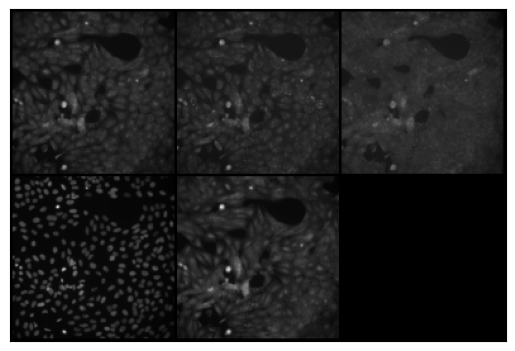

In [7]:
plot_cellpainting_image(image)

In order to diversify the amount of image, we add a set of transformations

In [10]:
transforms = v2.Compose([
    #v2.RandomRotation(degrees=(0, 180)),
    v2.ToDtype(torch.float32, scale=True) # This also set the values of the tensor between 0 and 1
])

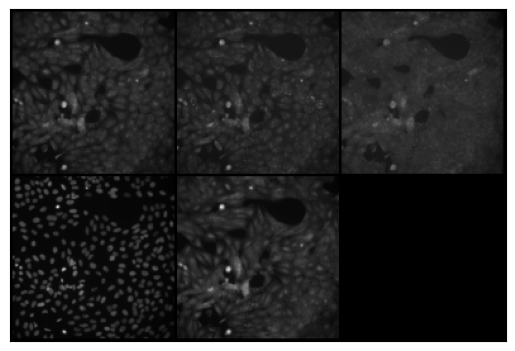

In [11]:
timg = transforms(image)
plot_cellpainting_image(timg)

We ca now load the full dataset in memory with our newly defined transforms, for testinmg purpose we split into 2 datasets, opne for training and one for validation.

In [12]:
test_frac = 0.2
paths = [x for x in os.listdir(PATH_IMAGES) if x.endswith(".pt")]

paths_train = np.random.choice(paths,size=int(len(paths)*(1-test_frac)),replace=False)
paths_test = [x for x in paths if x not in paths_train]

print("THere is {} training images and {} test images".format(len(paths_train),len(paths_test)))

THere is 5544 training images and 1386 test images


In [13]:
ds_train = CellPaintingDatasetInMemory(root=PATH_IMAGES,transform=transforms, paths=paths_train)
ds_test = CellPaintingDatasetInMemory(root=PATH_IMAGES,transform=transforms, paths=paths_test)

100%|██████████| 1386/1386 [00:37<00:00, 36.93it/s]


No in order to perform the learning we need to create batches, this can be performed using a dataloader.

In [14]:
BATCH_SIZE = 32

In [15]:
dl_train = torch.utils.data.DataLoader(ds_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=4)
dl_test = torch.utils.data.DataLoader(ds_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=4)

In this case we allow the shulffing of the data as they are all in memory and the order in which we fetch the data should nbot affect the loading speed.

### Logging

We log the image generation using tensorboard for image generation

In [19]:
PATH_LOGS = os.path.join(os.getcwd(),"log_tensorboard")
if os.path.exists(PATH_LOGS):
    shutil.rmtree(PATH_LOGS)

print("Logging for tensorboard in '{}'".format(PATH_LOGS))

Logging for tensorboard in '/mnt/c/Users/alexi/Documents/dev/portfolio/imaging/segmentation/src/notebooks/log_tensorboard'


# Generating images

## VAE 
A reliable baseline module is the VAE, so we first use that

In [28]:
# TO quickly reload
import gencellpainting.model.VAE as VAE
importlib.reload(VAE)

<module 'gencellpainting.model.VAE' from '/mnt/c/Users/alexi/Documents/dev/portfolio/imaging/segmentation/src/notebooks/../gencellpainting/model/VAE.py'>

We add the data

In [ ]:
mVAE = VAE.VAE(latent_dim=1024, in_channels=ds_test.n_channels, out_channels=ds_test.n_channels,\
               epoch_monitoring_interval=1, n_images_monitoring=3, alpha = 0.01, learning_rate=1e-3)

We configure the trainer, with an early stopping case

In [30]:
NAME_MODEL = "VAE"
plogs = os.path.join(PATH_LOGS,NAME_MODEL)
if os.path.isdir(plogs):
    shutil.rmtree(plogs)
tb_logger = L.pytorch.loggers.TensorBoardLogger(save_dir = PATH_LOGS, name=NAME_MODEL)

In [31]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
early_stopping = L.pytorch.callbacks.early_stopping.EarlyStopping(monitor="val_loss", mode="min", patience=3)
trainer = L.Trainer(max_epochs=50, accelerator="gpu", devices=1, logger=tb_logger, callbacks=[early_stopping])

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [32]:
trainer.fit(mVAE, train_dataloaders=dl_train, val_dataloaders=dl_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name                  | Type                | Params | Mode 
----------------------------------------------------------------------
0 | clip_frechet_distance | FrechetCLIPDistance | 151 M  | train
1 | encoder               | EncoderWithPooling  | 8.5 M  | train
2 | decoder               | Decoder             | 9.6 M  | train
----------------------------------------------------------------------
18.1 M    Trainable params
151 M     Non-trainable params
169 M     Total params
677.386   Total estimated model params size (MB)
48        Modules in train mode
307       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/adelabriere/miniconda3/envs/imaging/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Epoch 2:  84%|████████▍ | 146/174 [00:12<00:02, 12.03it/s, v_num=0, train_mse_step=0.00979, train_kl_step=4.12e+3, total_loss_step=41.20, val_loss=0.0213, train_mse_epoch=0.0377, train_kl_epoch=6.69e+3, total_loss_epoch=67.00]


Detected KeyboardInterrupt, attempting graceful shutdown ...


Epoch 5: 100%|██████████| 174/174 [01:47<00:00,  1.62it/s, v_num=0, train_mse_step=0.0035, train_kl_step=7.65e+3, total_loss_step=76.50, val_loss=0.00353, train_mse_epoch=0.00353, train_kl_epoch=7.68e+3, total_loss_epoch=76.80]


NameError: name 'exit' is not defined

In [47]:
b1 = ds_test[100]
b1 = b1.unsqueeze(0)
b1.shape

torch.Size([1, 5, 128, 128])

In [33]:
y1 = mVAE.decoder(mVAE.encoder(b1).sample())

[torch.Size([1, 128, 128]), torch.Size([1, 128, 128]), torch.Size([1, 128, 128]), torch.Size([1, 128, 128]), torch.Size([1, 128, 128])]


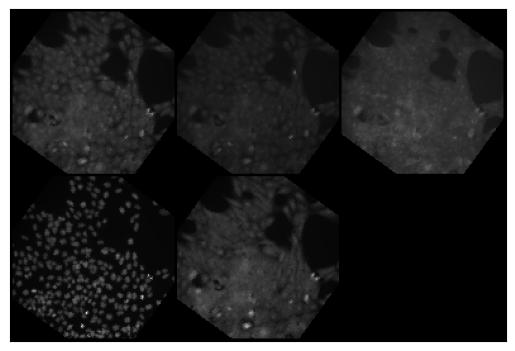

In [34]:
plot_cellpainting_image(b1.squeeze())

[torch.Size([1, 128, 128]), torch.Size([1, 128, 128]), torch.Size([1, 128, 128]), torch.Size([1, 128, 128]), torch.Size([1, 128, 128])]


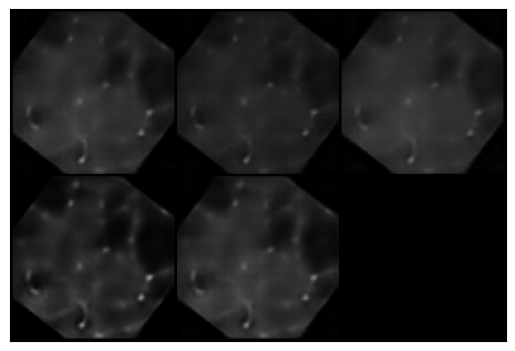

In [35]:
plot_cellpainting_image(y1.squeeze())

## Generative Adversarial Network (GAN)


In [17]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

In [20]:
import gencellpainting.model.GAN as GAN
GAN = importlib.reload(GAN)

Defining the logger

In [23]:
mGAN = GAN.GAN(in_channels=ds_train.n_channels,out_channels=ds_train.n_channels,noise_dim=512)


We can similary ltrain the model

In [24]:
tb_logger = L.pytorch.loggers.TensorBoardLogger(save_dir = PATH_LOGS, name="GAN")
gan_trainer = L.Trainer(max_epochs=30, accelerator="gpu", devices=1, logger=tb_logger,)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [25]:
gan_trainer.fit(mGAN, train_dataloaders=dl_train)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name          | Type                 | Params | Mode 
---------------------------------------------------------------
0 | generator     | GeneratorV2ShallowFC | 9.1 M  | train
1 | discriminator | Discriminator        | 142 K  | train
---------------------------------------------------------------
9.2 M     Trainable params
0         Non-trainable params
9.2 M     Total params
36.955    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Epoch 29: 100%|██████████| 87/87 [00:06<00:00, 13.50it/s, v_num=1, loss_d=0.586, loss_g=1.870, loss_d_real=0.478, loss_d_fake=0.108]      

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 87/87 [00:07<00:00, 11.69it/s, v_num=1, loss_d=0.586, loss_g=1.870, loss_d_real=0.478, loss_d_fake=0.108]


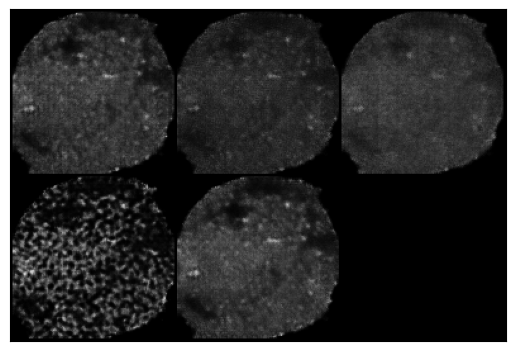

In [164]:
# Sampling an image for demonstration
y1_gan = mGAN.generator(mGAN.sample_z(1))
plot_cellpainting_image(y1_gan.squeeze())

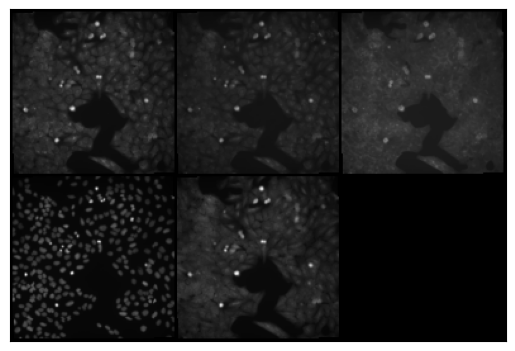

In [72]:
# Plotting a real image
plot_cellpainting_image(b1.squeeze())

While the image looks fine from afar, we clearly see some limitation, too dense nuclei frame (4th) image and checkerboard patterns.

### Wasserstein GAN

The Wasserstein GAN are a more stable version of GAN, and to be frank I am just curious of their performance.

In [17]:
NCRITICS = 3

In [18]:
ds_train_W = WGANCriticDataset(ds_train,ncritic=NCRITICS)
ds_test_W = WGANCriticDataset(ds_test,ncritic=NCRITICS)

In order for the dataloader to know how to stitch a batch together we put everything together the `collate_fn` argument

In [28]:
# This funciton will retirn aa tuple with 2 elements
# 1. The images to process with the generator (B x C x H x W)
# 2. The images to process with the discirminator for learning ( (B x NCRITIC) x C x H x W) 
def collate_wgan_batch(batch):
    gen_imgs,disc_imgs = zip(*batch)
    gen_imgs = torch.stack(gen_imgs)
    disc_imgs = torch.stack([y for subbatch in disc_imgs for y in subbatch ])
    return gen_imgs, disc_imgs

In [29]:
dl_train_W = torch.utils.data.DataLoader(ds_train_W,batch_size=32,shuffle=True, collate_fn=collate_wgan_batch, num_workers=4)
dl_test_W = torch.utils.data.DataLoader(ds_test_W,batch_size=32,shuffle=True, collate_fn=collate_wgan_batch, num_workers=4)

We define the logging folders

In [84]:
tbatch = next(iter(dl_train_W))
train_real,train_disc = tbatch

We can now test the model

In [171]:
import gencellpainting.model.WGAN as WGAN
importlib.reload(WGAN)

ModuleNotFoundError: No module named 'conv_modules'

In [172]:
wgan = WGAN.WGAN(in_channels=ds_train.n_channels,out_channels=ds_train.n_channels,noise_dim=512,n_critic=NCRITICS, clip_value=0.01, learning_rate = 1e-5)

NameError: name 'WGAN' is not defined

In [183]:
tb_logger = L.pytorch.loggers.TensorBoardLogger(save_dir = PATH_LOGS, name="WGAN")
trainer_wg = L.Trainer(max_epochs=10,accelerator="gpu",devices=1, logger=tb_logger)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [184]:
trainer_wg.fit(wgan,dl_train_W)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                 | Params | Mode 
---------------------------------------------------------------
0 | generator     | GeneratorV2ShallowFC | 9.1 M  | train
1 | discriminator | WGANCritic           | 142 K  | train
---------------------------------------------------------------
9.2 M     Trainable params
0         Non-trainable params
9.2 M     Total params
36.955    Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


Epoch 7:  37%|███▋      | 65/174 [00:08<00:13,  7.98it/s, v_num=10, G_loss=2.320, D_loss=-3.95, d_R=-1.63, d_G=2.310]           


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

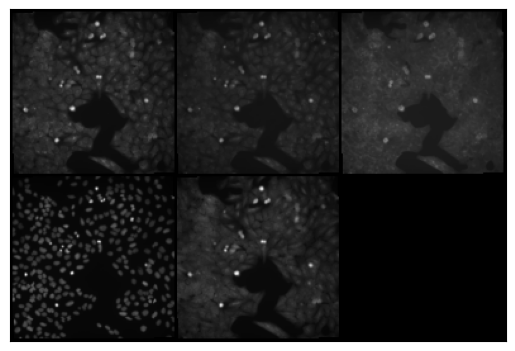

In [169]:
plot_cellpainting_image(b1.squeeze())

## Investigation into the problem of image genration

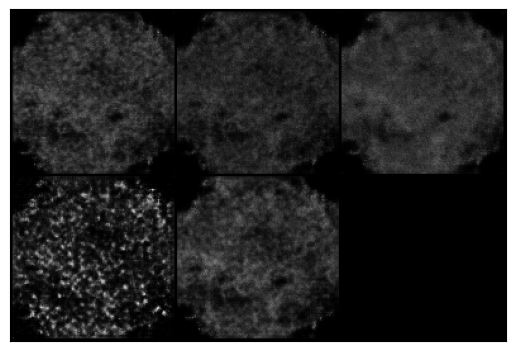

In [170]:
y1_wgan = wgan.generator(wgan.sample_z(4))
plot_cellpainting_image(y1_wgan[2,:,:,:].squeeze())

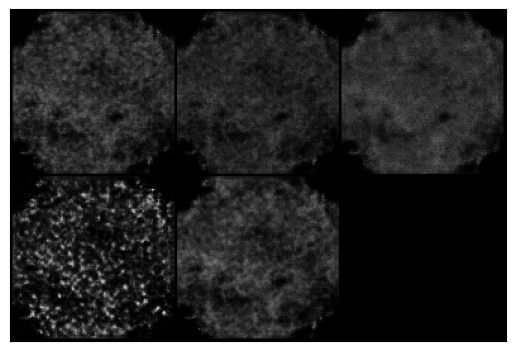

In [171]:
plot_cellpainting_image(y1_wgan[0,:,:,:].squeeze())

### SimpleGAN2
SimpleGAN2 is a more complex GAN including feature from StyleGAN2, its main features are:
* __Style embedding:__ The noise vector is embedded into a disentangled space.
* __Progressive growth:__ The generator gros the image progressively, the style is added at each step.

In [2]:
import gencellpainting.model.styleGANV2 as SG2
importlib.reload(SG2)

ModuleNotFoundError: No module named 'gencellpainting'

THis seciton si for dbugging purpose. We select a subset of the batgch to make the debugging easier

In [19]:
import functools

In [20]:
# This funciton will retirn aa tuple with 2 elements
# 1. The images to process with the generator (B x C x H x W)
# 2. The images to process with the discirminator for learning ( (B x NCRITIC) x C x H x W) 
def collate_wgan_batch_dbug(batch,min_idx=0,max_idx=None, sel_batch = None):
    gen_imgs,disc_imgs = zip(*batch)
    gen_imgs = torch.stack(gen_imgs)
    if max_idx is None:
        max_idx = gen_imgs.shape[2]
    if sel_batch is None:
        sel_batch = [ix for ix in range(gen_imgs.shape[1])]
    disc_imgs = torch.stack([y for subbatch in disc_imgs for y in subbatch ])
    gen_imgs = gen_imgs[:,sel_batch,min_idx:max_idx,min_idx:max_idx]
    disc_imgs = disc_imgs [:,sel_batch,min_idx:max_idx,min_idx:max_idx]
    return gen_imgs, disc_imgs

sel_min_idx = 32
sel_max_idx = 96
sel_pos = [0,3]

collate_fn_sg2 = functools.partial(collate_wgan_batch_dbug, min_idx=sel_min_idx, max_idx=sel_max_idx, sel_batch = sel_pos)

In [21]:

dl_train_sg2 = torch.utils.data.DataLoader(ds_train_W,batch_size=32,shuffle=True, collate_fn=collate_fn_sg2, num_workers=4)


In [22]:
batch = next(iter(dl_train_sg2))

In [23]:
batch[0].shape

torch.Size([32, 2, 64, 64])

In [ ]:
plot_cellpainting_image()

We define the network

In [ ]:
sg2gan = SG2.SG2SimpleGAN(latent_dim = 512, image_channel = batch[0].shape[1], image_size = batch[0].shape[2], style_depth=6, network_capacity=12,\
                 disc_training_interval=1, epoch_monitoring_interval=1, n_images_monitoring=6, learning_rate = 5e-4)

i 768 384
i 384 192
i 192 96
i 96 48
imaghe_size 64 last_dim 3072 [2, 48, 96, 192, 384, 768]


In [261]:
tb_logger = L.pytorch.loggers.TensorBoardLogger(save_dir = PATH_LOGS, name="SG2")
plogs = os.path.join(PATH_LOGS,"SG2")
if os.path.isdir(plogs):
    shutil.rmtree(plogs)
trainer_sg2 = L.Trainer(max_epochs=10,accelerator="gpu",devices=1, logger=tb_logger)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [262]:
trainer_sg2.fit(sg2gan,dl_train_sg2)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type          | Params | Mode 
-----------------------------------------------
0 | G    | Generator     | 6.8 M  | train
1 | D    | Discriminator | 18.1 M | train
2 | Snet | StyleEncoder  | 1.6 M  | train
-----------------------------------------------
26.4 M    Trainable params
0         Non-trainable params
26.4 M    Total params
105.715   Total estimated model params size (MB)
116       Modules in train mode
0         Modules in eval mode


Epoch 4:  43%|████▎     | 75/174 [00:24<00:32,  3.06it/s, v_num=0, disc_loss_step=1.410, gen_loss_step=0.711, disc_loss_epoch=1.400, gen_loss_epoch=0.650] 


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

### Debugging corner

This section is jsut to debug the NNs

In [81]:
from conv_modules import UpsampleConvStack

In [ ]:
UpsampleConvStack

conv_modules.UpsampleConvStack